# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: whole sphere classification

Note: DeepSphere is included in the system (inside /usr/lib64), but some methods like models.fit, might expect to have write access inside the module directory. If you can't change the write directory from the methods arguments, you can bring your own deepsphere module into the system. 

In [1]:
%%bash
# Clone repository if it hasn't been done already
cd /scratch365/$(whoami)
if [ ! -d DeepSphere ]; then
    git clone https://github.com/NDCMS/DeepSphere/
fi

Now, you can add this package in the system. You will need to call the module like: DeepSphere.deepsphere, importing just "deepsphere" will use the system's module ins

In [2]:
import os
import sys
import getpass
sys.path.insert(0,'/scratch365/{user}/DeepSphere'.format(user=getpass.getuser()))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import shutil

# Run on CPU.
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import healpy as hp
import tensorflow as tf
from deepsphere import models, experiment_helper, plot
from deepsphere.data import LabeledDataset

In [5]:
# Show GPU devices available
print(tf.__version__)
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
    print("TensorFlow version: {0}".format(tf.__version__))
else:
    print("Could not find GPU device")

1.15.2
/device:GPU:0
TensorFlow version: 1.15.2


In [6]:
plt.rcParams['figure.figsize'] = (17, 5)

In [7]:
EXP_NAME = 'whole_sphere'

## 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with. It is made of 200 maps of size `NSIDE=64` splitted into 2 classes. 

The maps contain a Gaussian random field realisations produced with Synfast function from Healpy package.
The input power spectra were taken from LambdaCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `Nside=64` in order to make the processing faster.

In [8]:
data = np.load('data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to visually catch the differences.

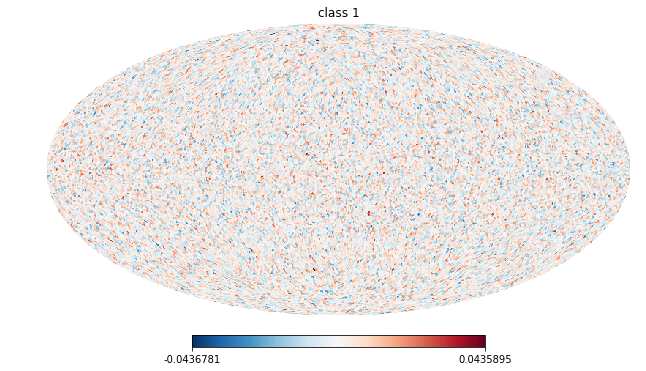

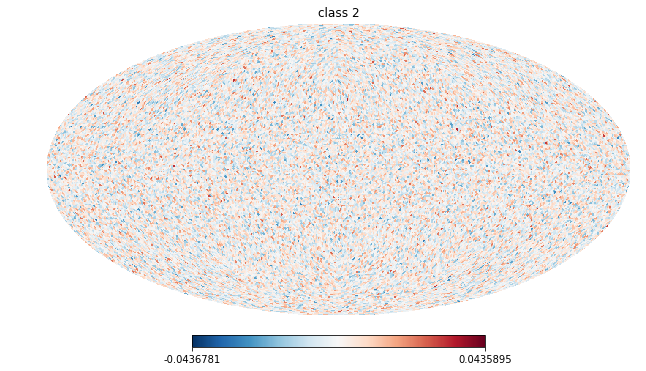

In [9]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
cm = plt.cm.RdBu_r
cm.set_under('w')
hp.mollview(data['class1'][0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(data['class2'][0], title='class 2', nest=True, cmap=cm, min=cmin, max=cmax)

However, those maps have different Power Spectral Densities PSD.

In [10]:
sample_psd_class1 = np.empty((nclass, 192))
sample_psd_class2 = np.empty((nclass, 192))

for i in range(nclass):
    sample_psd_class1[i] = experiment_helper.psd(data['class1'][i])
    sample_psd_class2[i] = experiment_helper.psd(data['class2'][i])

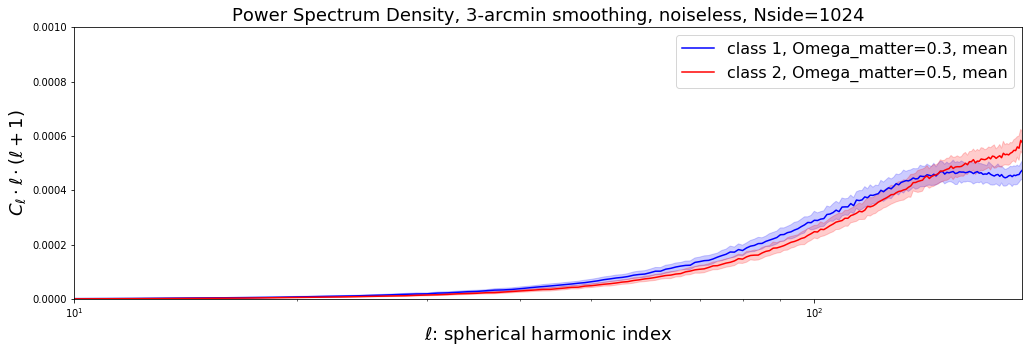

In [11]:
ell = np.arange(sample_psd_class1.shape[1])
plot.plot_with_std(ell, sample_psd_class1*ell*(ell+1), label='class 1, Omega_matter=0.3, mean', color='b')
plot.plot_with_std(ell,sample_psd_class2*ell*(ell+1), label='class 2, Omega_matter=0.5, mean', color='r')
plt.legend(fontsize=16);
plt.xlim([10, np.max(ell)])
plt.ylim([1e-6, 1e-3])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index', fontsize=18)
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$', fontsize=18)
plt.title('Power Spectrum Density, 3-arcmin smoothing, noiseless, Nside=1024', fontsize=18);

## 2 Data preparation

Let us split the data into training and testing sets. The raw data is stored into `x_raw` and the power spectrum densities into `x_psd`.

In [12]:
# Normalize and transform the data, i.e. extract features.
x_raw = np.vstack((data['class1'], data['class2']))
x_raw = x_raw / np.mean(x_raw**2) # Apply some normalization (We do not want to affect the mean)
x_psd = preprocessing.scale(np.vstack((sample_psd_class1, sample_psd_class2)))

# Create the label vector
labels = np.zeros([x_raw.shape[0]], dtype=int)
labels[nclass:] = 1

# Random train / test split
ntrain = 150
ret = train_test_split(x_raw, x_psd, labels, test_size=2*nclass-ntrain, shuffle=True)
x_raw_train, x_raw_test, x_psd_train, x_psd_test, labels_train, labels_test = ret

print('Class 1 VS class 2')
print('  Training set: {} / {}'.format(np.sum(labels_train==0), np.sum(labels_train==1)))
print('  Test set: {} / {}'.format(np.sum(labels_test==0), np.sum(labels_test==1)))

Class 1 VS class 2
  Training set: 75 / 75
  Test set: 25 / 25


## 3 Classification using SVM

As a baseline, let us classify our data using an SVM classifier.

* An SVM based on the raw feature cannot discriminate the data because the dimensionality of the data is too large.
* We however observe that the PSD features are linearly separable.

In [13]:
clf = SVC(kernel='rbf')
clf.fit(x_raw_train, labels_train) 

e_train = experiment_helper.model_error(clf, x_raw_train, labels_train)
e_test = experiment_helper.model_error(clf, x_raw_test, labels_test)
print('The training error is: {}%'.format(e_train*100))
print('The testing error is: {}%'.format(e_test*100))

The training error is: 0.0%
The testing error is: 50.0%


In [14]:
clf = SVC(kernel='linear')
clf.fit(x_psd_train, labels_train) 

e_train = experiment_helper.model_error(clf, x_psd_train, labels_train)
e_test = experiment_helper.model_error(clf, x_psd_test, labels_test)
print('The training error is: {}%'.format(e_train*100))
print('The testing error is: {}%'.format(e_test*100))

The training error is: 0.0%
The testing error is: 0.0%


## 4 Classification using DeepSphere

Let us now classify our data using a spherical convolutional neural network.

Three types of architectures are suitable for this task:
1. Classic CNN: the classic ConvNet composed of some convolutional layers followed by some fully connected layers.
2. Stat layer: a statistical layer, which computes some statistics over the pixels, is inserted between the convolutional and fully connected layers. The role of this added layer is make the prediction invariant to the position of the pixels on the sphere.
3. Fully convolutional: the fully connected layers are removed and the network outputs many predictions at various spatial locations that are then averaged.

On this simple task, all architectures can reach 100% test accuracy. Nevertheless, the number of parameters to learn decreases and training converges faster. A fully convolutional network is much faster and efficient in terms of parameters. It does however assume that all pixels have the same importance and that their location does not matter. While that is true for cosmological applications, it may not for others.

In [15]:
params = dict()
params['dir_name'] = EXP_NAME

# Types of layers.
params['conv'] = 'chebyshev5'  # Graph convolution: chebyshev5 or monomials.
params['pool'] = 'max'  # Pooling: max or average.
params['activation'] = 'relu'  # Non-linearity: relu, elu, leaky_relu, softmax, tanh, etc.
params['statistics'] = None  # Statistics (for invariance): None, mean, var, meanvar, hist.

# Architecture.
architecture = 'fully_convolutional'

if architecture == 'classic_cnn':
    params['statistics'] = None
    params['nsides'] = [64, 32, 16, 16]  # Pooling: number of pixels per layer.
    params['F'] = [5, 5, 5]  # Graph convolutional layers: number of feature maps.
    params['M'] = [50, 2]  # Fully connected layers: output dimensionalities.

elif architecture == 'stat_layer':
    params['statistics'] = 'meanvar'
    params['nsides'] = [64, 32, 16, 16]  # Pooling: number of pixels per layer.
    params['F'] = [5, 5, 5]  # Graph convolutional layers: number of feature maps.
    params['M'] = [50, 2]  # Fully connected layers: output dimensionalities.

elif architecture == 'fully_convolutional':
    params['statistics'] = 'mean'
    params['nsides'] = [64, 32, 16, 8, 8]
    params['F'] = [5, 5, 5, 2]
    params['M'] = []

params['K'] = [10] * len(params['F'])  # Polynomial orders.
params['batch_norm'] = [True] * len(params['F'])  # Batch normalization.

# Regularization.
params['regularization'] = 0  # Amount of L2 regularization over the weights (will be divided by the number of weights).
params['dropout'] = 0.5  # Percentage of neurons to keep.

# Training.
params['num_epochs'] = 12  # Number of passes through the training data.
params['batch_size'] = 16  # Number of samples per training batch. Should be a power of 2 for greater speed.
params['eval_frequency'] = 15  # Frequency of model evaluations during training (influence training time).
params['scheduler'] = lambda step: 1e-1  # Constant learning rate.
params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
#params['optimizer'] = lambda lr: tf.train.MomentumOptimizer(lr, momentum=0.5)
#params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)

In [16]:
model = models.deepsphere(**params)

NN architecture
  input: M_0 = 49152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 49152 * 5 / 4 = 61440
    weights: F_0 * F_1 * K_1 = 1 * 5 * 10 = 50
    biases: F_1 = 5
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12288 * 5 / 4 = 15360
    weights: F_1 * F_2 * K_2 = 5 * 5 * 10 = 250
    biases: F_2 = 5
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 3072 * 5 / 4 = 3840
    weights: F_2 * F_3 * K_3 = 5 * 5 * 10 = 250
    biases: F_3 = 5
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 768 * 2 / 1 = 1536
    weights: F_3 * F_4 * K_4 = 5 * 2 * 10 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 2 = 2



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [17]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [18]:
training = LabeledDataset(x_raw_train, labels_train)
testing = LabeledDataset(x_raw_test, labels_test)

In [19]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, testing)

step 15 / 112 (epoch 1.60 / 12):
  learning_rate = 1.00e-01, training loss = 1.45e-02
  validation accuracy: 50.00 (25 / 50), f1 (weighted): 33.33, loss: 3.69e+00
  CPU time: 6s, wall time: 160s



/usr/local/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



step 30 / 112 (epoch 3.20 / 12):
  learning_rate = 1.00e-01, training loss = 1.02e-02
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 9.88e-03
  CPU time: 8s, wall time: 162s
step 45 / 112 (epoch 4.80 / 12):
  learning_rate = 1.00e-01, training loss = 7.20e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 3.46e-03
  CPU time: 9s, wall time: 163s
step 60 / 112 (epoch 6.40 / 12):
  learning_rate = 1.00e-01, training loss = 6.16e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 2.20e-03
  CPU time: 10s, wall time: 164s
step 75 / 112 (epoch 8.00 / 12):
  learning_rate = 1.00e-01, training loss = 2.27e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 1.88e-03
  CPU time: 11s, wall time: 165s
step 90 / 112 (epoch 9.60 / 12):
  learning_rate = 1.00e-01, training loss = 1.43e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 1.22e-03
  CPU time: 13s, wall time: 166s
Instructions

Instructions for updating:
Use standard file APIs to delete files with this prefix.


step 105 / 112 (epoch 11.20 / 12):
  learning_rate = 1.00e-01, training loss = 3.16e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 1.14e-03
  CPU time: 14s, wall time: 167s
step 112 / 112 (epoch 11.95 / 12):
  learning_rate = 1.00e-01, training loss = 2.06e-03
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 1.05e-03
  CPU time: 14s, wall time: 168s
validation accuracy: best = 100.00, mean = 93.75


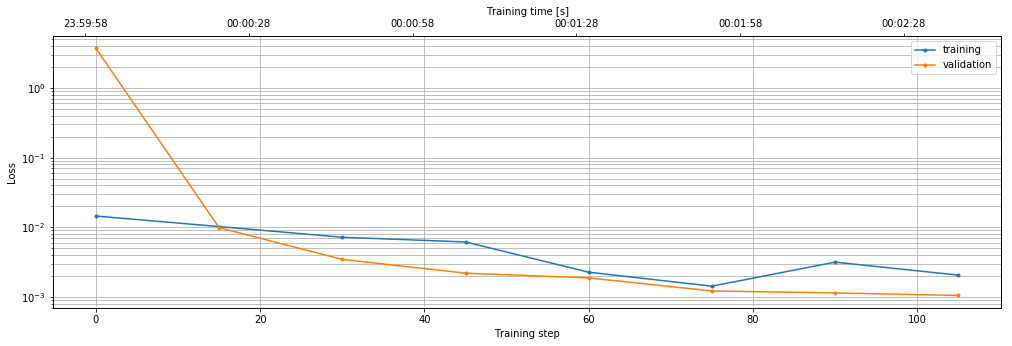

In [20]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [21]:
error_train = experiment_helper.model_error(model, x_raw_train, labels_train)
error_test = experiment_helper.model_error(model, x_raw_test, labels_test)
print('The training error is: {:.2%}'.format(error_train))
print('The testing error is: {:.2%}'.format(error_test))

/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


The training error is: 0.00%
The testing error is: 0.00%


## 5 Filters visualization

The package offers a few different visualizations for the learned filters. First we can simply look at the Chebyshef coefficients. This visualization is not very interpretable for human, but can help for debugging problems related to optimization.

/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


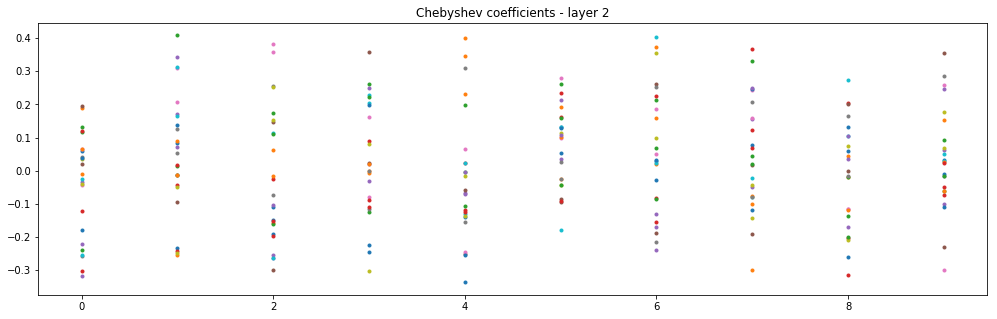

In [22]:
layer=2
model.plot_chebyshev_coeffs(layer)

We observe the Chebyshef polynomial, i.e the filters in the graph spectral domain. This visuallization can help to understand wich graph frequencies are picked by the filtering operation. It mostly interpretable by the people for the graph signal processing community.

/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


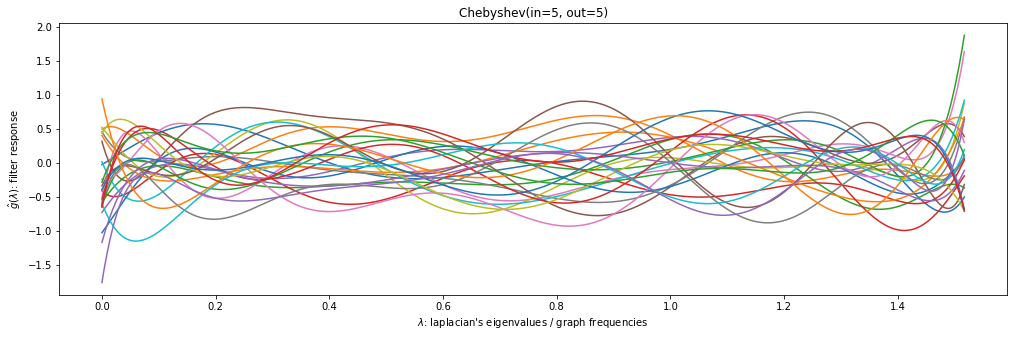

In [23]:
model.plot_filters_spectral(layer);

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


5 5


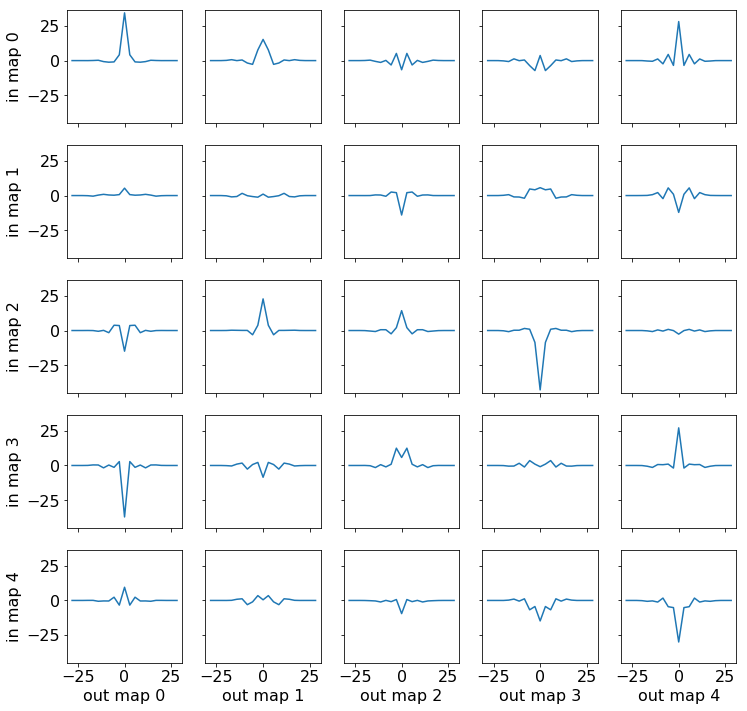

In [24]:
mpl.rcParams.update({'font.size': 16})
model.plot_filters_section(layer, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

/scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere
INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


INFO:tensorflow:Restoring parameters from /scratch365/khurtado/DeepSphere/deepsphere/../checkpoints/whole_sphere/model-112


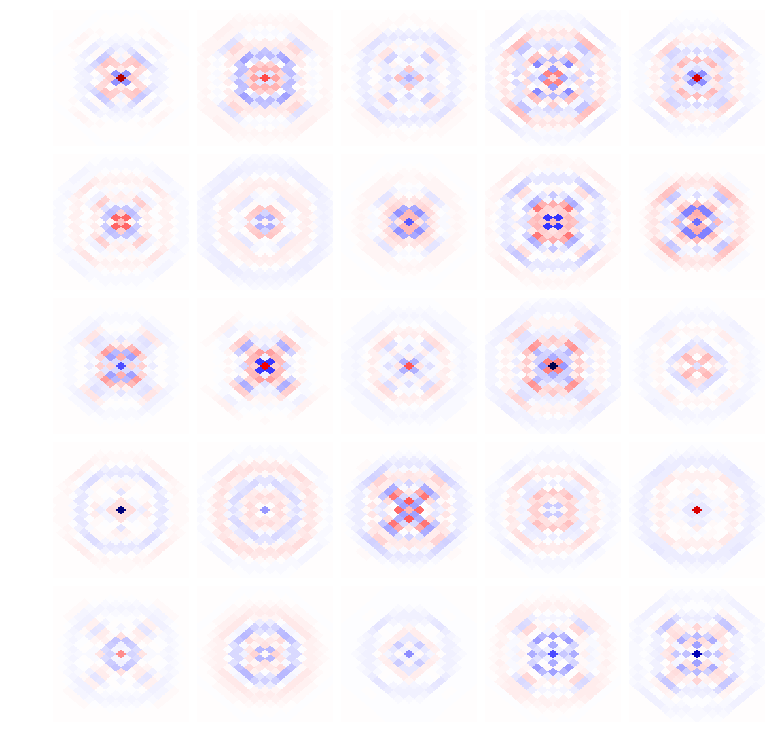

In [25]:
plt.rcParams['figure.figsize'] = (10, 10)
model.plot_filters_gnomonic(layer, title='')